In [2]:
import gdal
import datetime
import os
import random
import sys
import tarfile
import zipfile
from glob import glob
from os.path import join, splitext, exists

import numpy as np
import requests
import scipy.io
import tensorflow as tf
from scipy.misc import imread, imsave, imresize
from tensorflow.python.platform import gfile

import matplotlib.pylab as plt
%matplotlib inline

In [17]:

class BatchDataset:
    files = []
    images = []
    annotations = []
    image_options = {}
    batch_offset = 0
    epochs_completed = 0

    def __init__(self, directory, ext, resize, size, mask_ext='png', filename=None):
        """
        Initialize a generic file reader with batching for list of files
        :param mask_ext:
        :param ext:
        :param directory:
        sample record: {'image': f, 'annotation': annotation_file, 'filename': filename}
        Available options:
        resize = True/ False
        resize_size = #size of output image - does bilinear resize
        color=True/False
        """
        records = []
        if gfile.Exists(join(directory, filename)):
            with open(join(directory, filename)) as f:
                file_list = [join(directory, IMAGES, image) for image in f.read().split()]
        else:
            file_list = glob(join(directory, IMAGES, '*.{}'.format(ext)))

        if not file_list:
            print('No files found')
            raise FileNotFoundError()
        else:
            for f in file_list:
                filename = splitext(f.split("/")[-1])[0]
                mask_file = join(directory, ANNOTATIONS, filename + '.' + mask_ext)
                if exists(mask_file):
                    records.append(Record(f, mask_file))
                else:
                    print("Annotation file not found for %s - Skipping" % filename)

        random.shuffle(records)
        self.records = records
        print('No. of %s files: %d' % (directory, (len(records))))

        self.resize = resize
        self.size = size
        print("Initializing Batch Dataset Reader...")
        # todo TIF reading and manipulation
        if ext == 'tif':
            self.images = np.array([self.transform_tif(record.image) for record in records])
        else:
            self.images = np.array([self.transform(imread(record.image)) for record in records])
        self.annotations = np.array(
            [np.expand_dims(self.transform_mask(imread(record.mask)), axis=3) for record in records])
        self.batch_offset = 0
        print(self.images.shape)
        print(self.annotations.shape)

    def transform(self, image, mask=False):
        if self.resize:
            image = np.array(imresize(image, [self.size, self.size], interp='nearest'))

        if not mask and len(image.shape) < 3:  # make sure images are of shape(h,w,3)
            image = np.array([image] * IMG_CHANNELS)
        elif not mask and image.shape[-1] < IMG_CHANNELS:  # make sure images are of shape(h,w,3)
            image = np.dstack([image] * (1 + IMG_CHANNELS // image.shape[-1]))[:, :, :IMG_CHANNELS]

        if mask and image.shape[-1] > 1:
            # image = np.dot(image[..., :3], [0.299/128, 0.587/128, 0.114/128])
            image = (image.sum(axis=-1) > 0).astype(np.int)

        return np.array(image)

    def transform_mask(self, image):
        if self.resize:
            image = np.array(imresize(image, [self.size, self.size], interp='nearest'))

        if len(image.shape) > 2 and image.shape[-1] > 1:
            # image = np.dot(image[..., :3], [0.299/128, 0.587/128, 0.114/128])
            image = (image.sum(axis=-1) > 0).astype(np.int)
        image = (image > 0).astype(np.int)

        return np.array(image)

    def next_batch(self, batch_size):
        start = self.batch_offset
        self.batch_offset += batch_size
        if self.batch_offset > self.images.shape[0]:
            # Finished epoch
            self.epochs_completed += 1
            print("****************** Epochs completed: " + str(self.epochs_completed) + "******************")
            # Shuffle the data
            perm = np.arange(self.images.shape[0])
            np.random.shuffle(perm)
            self.images = self.images[perm]
            self.annotations = self.annotations[perm]
            # Start next epoch
            start = 0
            self.batch_offset = batch_size

        end = self.batch_offset
        return self.images[start:end], self.annotations[start:end]

    def get_random_batch(self, batch_size):
        indexes = np.random.randint(0, self.images.shape[0], size=[batch_size]).tolist()
        return self.images[indexes], self.annotations[indexes], [self.records[index] for index in indexes]

    def transform_tif(self, image):
        i = gdal.Open(image, gdal.GA_ReadOnly).ReadAsArray()
        if self.resize:
            new_image = []
            for layer in i:
                new_layer = np.array(imresize(layer, [self.size, self.size], interp='nearest'))
                new_image.append(new_layer)
            i = np.array(new_image).transpose([1, 2, 0])
        return i

class Record:
    def __init__(self, image, mask):
        print(image, mask)
        self.image = image
        self.mask = mask



In [19]:
FLAGS = tf.flags.FLAGS
tf.flags.DEFINE_integer("batch_size", "2", "batch size for training")
tf.flags.DEFINE_string("logs_dir", "logs/", "path to logs directory")
tf.flags.DEFINE_string("data_dir", "powerplant/", "path to dataset")
tf.flags.DEFINE_string("train_dir", "", "path to dataset")
tf.flags.DEFINE_string("val_dir", "", "path to dataset")
tf.flags.DEFINE_float("learning_rate", "1e-4", "Learning rate for Adam Optimizer")
tf.flags.DEFINE_string("model_dir", "Model_zoo/", "Path to vgg model mat")
tf.flags.DEFINE_bool('debug', "True", "Debug mode: True/ False")
tf.flags.DEFINE_string('mode', "train", "Mode train/ test/ visualize")
tf.flags.DEFINE_integer('channels', "8", "number of channels in image")


MAX_ITERATION = int(1e5 + 1)
NUM_OF_CLASSES = 2
IMAGE_SIZE = 100
IMG_CHANNELS = FLAGS.channels


ANNOTATIONS = 'masks'  # "annotations"
IMAGES = "images"


In [26]:


print("Setting up dataset reader")
if not FLAGS.val_dir or not FLAGS.train_dir:
    train_dir = val_dir = FLAGS.data_dir
    train_batch = "train.txt"
    val_batch = "val.txt"
else:
    val_dir = FLAGS.val_dir
    train_dir = FLAGS.train_dir
    train_batch = val_batch = None

validation_dataset = BatchDataset(val_dir, 'tif', True, IMAGE_SIZE, filename=val_batch)


Setting up dataset reader
powerplant/images/0069636f-dc77-4a55-833d-00338760a483.tif powerplant/masks/0069636f-dc77-4a55-833d-00338760a483.png
powerplant/images/0117c134-d8a4-4e01-b3bf-b0e32c46d6ac.tif powerplant/masks/0117c134-d8a4-4e01-b3bf-b0e32c46d6ac.png
powerplant/images/040fb78b-7e3e-4672-94f0-25537b4aa74d.tif powerplant/masks/040fb78b-7e3e-4672-94f0-25537b4aa74d.png
powerplant/images/04c63991-75f8-4a9c-a071-8988934e21e9.tif powerplant/masks/04c63991-75f8-4a9c-a071-8988934e21e9.png
powerplant/images/071ab7b5-392d-4a9e-8ce1-c133a6e23f32.tif powerplant/masks/071ab7b5-392d-4a9e-8ce1-c133a6e23f32.png
powerplant/images/0872af2a-1d03-4217-88bc-786b94def45e.tif powerplant/masks/0872af2a-1d03-4217-88bc-786b94def45e.png
powerplant/images/094d10c1-ec2d-45ca-ab2a-979db09c2176.tif powerplant/masks/094d10c1-ec2d-45ca-ab2a-979db09c2176.png
powerplant/images/096387b5-f3a3-4891-9c0c-c593efcf2160.tif powerplant/masks/096387b5-f3a3-4891-9c0c-c593efcf2160.png
powerplant/images/09d143fc-d08b-416f-8

In [3]:
saver = tf.train.import_meta_graph('./logs/model.ckpt-93.meta')

sess = tf.Session()

saver.restore(sess, 'logs/model.ckpt-93')

graph = tf.get_default_graph()

In [74]:
valid_images, valid_annotations, recs = validation_dataset.get_random_batch(64)

In [75]:
%%time
pred = sess.run('inference/prediction:0', feed_dict={'input_image:0':valid_images,'keep_probability:0':1.0}) #image_placeholder: valid_images, annotation: valid_annotations, keep_probability: 1.0})

CPU times: user 1min 5s, sys: 2.87 s, total: 1min 7s
Wall time: 10.4 s


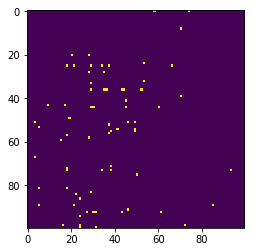

In [79]:
plt.imshow(pred[0])

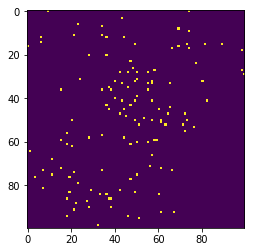

In [78]:
plt.imshow(pred[1])